## MG figures

In [27]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys

plt.style.use(r'C:\Users\nadia\OneDrive\Documents\GitHub\steinmetzlab\calcium imaging\ALpres.mplstyle')

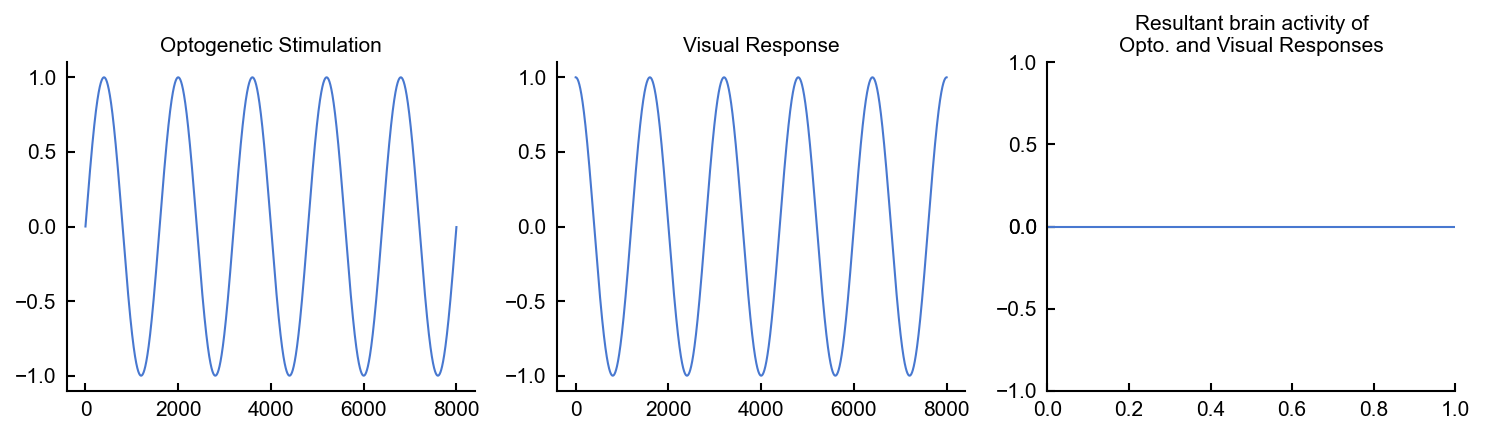

In [28]:
fig, axs = plt.subplots(1,3,figsize=(10,3))

Fs = 8000
f = 5
sample = 8000
x = np.arange(sample)
y_sin = np.sin(2 * np.pi * f * x / Fs)
y_cos = np.cos(2*np.pi*f*x/Fs)

axs[0].plot(x, y_sin)
axs[0].set_title("Optogenetic Stimulation")
axs[1].plot(x,y_cos)
axs[1].set_title("Visual Response")
axs[2].axhline(y=0)
axs[2].set_ylim([-1,1])
axs[2].set_title("Resultant brain activity of\nOpto. and Visual Responses")
axs[2].set_yticks([-1, 0, -.5, 0, .5, 1])

fig.tight_layout()
